In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import astropy.coordinates as coords
import astropy.units as u
from astropy.time import Time
from astroML.time_series import \
    lomb_scargle, lomb_scargle_bootstrap

from ztf_summerschool import source_lightcurve, barycenter_times
%matplotlib inline

#Hands-On Exercise 3:
Period Finding
========
One of the fundamental tasks of time-domain astronomy is determining if a source is periodic, and if so, measuring the period.  Period measurements are a vital first step for more detailed scientific study, which may include source classification (e.g., RR Lyrae, W Uma), lightcurve modeling (binaries), or luminosity estimation (Cepheids).

Binary stars in particular have lightcurves which may show a wide variety of shapes, depending on the nature of the stars and the system geometry.

In this workbook we will develop a basic toolset for the generic problem of finding periodic sources.

***
by Eric Bellm (2014-2015)

Let's use the relative-photometry corrected light curves we built in Exercise 2. We'll use the utility function `source_lightcurve` to load the columns MJD, magnitude, and magnitude error.  Note that we will use days as our time coordinate throughout the homework.

In [4]:
# point to our previously-saved data
reference_catalog = '../data/PTF_Refims_Files/PTF_d022683_f02_c06_u000114210_p12_sexcat.ctlg'
outfile = reference_catalog.split('/')[-1].replace('ctlg','shlv')

We'll start by loading the data from our favorite star, which has coordinates $\alpha_\mathrm{J2000}, \delta_\mathrm{J2000} = (312.503802, -0.706603)$.

In [5]:
ra_fav, dec_fav = (312.503802, -0.706603)
mjds, mags, magerrs = source_lightcurve('../data/'+outfile, ra_fav, dec_fav)

## Exercise 0

Our times are Modified Julian Date *on earth*.  We need to correct them for Earth's motion around the sun (this is called heliocentering or barycentering).  How big is the error if we do not make this correction?


In [4]:
# CALCULATE AN ANSWER HERE
import astropy.constants as const
(const.au/const.c).to(u.min)

<Quantity 8.316746397269274 min>

We have provided a script to barycenter the data--note that it assumes that the data come from the P48.  Use the `bjds` variable through the remainder of this notebook.

In [6]:
bjds = barycenter_times(mjds,ra_fav,dec_fav)

*Optional exercise: plot a histogram of the time differences between the barycentered and non-barycentered data.*

## Exercise 1

Complete this function for plotting the lightcurve:


In [13]:
# define plot function
def plot_data(mjd, mag, magerr): # COMPLETE THIS LINE
    plt.errorbar(mjd, mag, yerr=magerr, # COMPLETE THIS LINE
        fmt = '_', capsize=0)
    plt.xlabel('Date (MJD)')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()

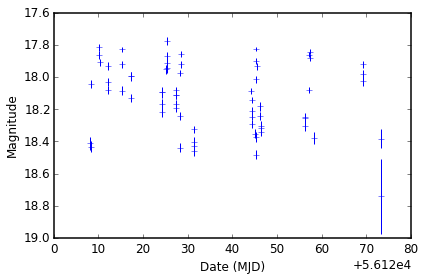

In [14]:
# run plot function
plot_data(bjds, mags, magerrs)

## The Lomb Scargle Periodogram

The [Lomb-Scarge Periodogram](http://adsabs.harvard.edu/abs/1982ApJ...263..835S) provides a method for searching for periodicities in time-series data.  It is comparable to the discrete Fourier Transform, but may be applied to irregularly sampled data.  The periodogram gives as output the relative significance of a least-squares sinusoidal fit to the data as a function of frequency.

Much of this presentation follows Ch. 10 of [Ivezic et al.](http://press.princeton.edu/titles/10159.html)

We use the "[generalized](http://adsabs.harvard.edu/abs/2009A%26A...496..577Z)" LS version implemented in astroML rather than the "standard" version implemented in scipy: the generalized version accounts better for data sampled unevenly in phase

In [ ]:
# documentation for the lomb_scargle function
help(lomb_scargle)

## Exercise 2

One of the challenges of using the LS periodogram is determining the appropriate frequency grid to search.  We have to select the minimum and maximum frequencies as well as the bin size.

If we don't include the true frequency in our search range, we can't find the period!

If the bins are too coarse, true peaks may be lost.  If the bins are too fine, the periodogram becomes very slow to compute.

The first question to ask is what range of frequencies our data is sensitive to.

### Exercise 2.1

What is the smallest angular frequency $\omega_{\rm min}$ our data is sensitive to?  (Hint: smallest frequency => largest time)

In [16]:
freq_min =  2*np.pi / (bjds[-1]-bjds[0]) # COMPLETE
print 'The minimum frequency our data is sensitive to is {:.3f} radian/days, corresponding to a period of {:.3f} days'.format(freq_min, 2*np.pi/freq_min)

The minimum frequency our data is sensitive to is 0.096 radian/days, corresponding to a period of 65.125 days


### Exercise 2.2

Determining the highest frequency we are sensitive to turns out to be complicated.  

if $\Delta t$ is the difference between consecutive observations,
$\pi$/median($\Delta t$) is a good starting point, although in practice we may be sensitive to frequencies even higher than $2 \pi$/min($\Delta t$) depending on the details of the sampling.

What is the largest angular frequency $\omega_{\rm max}$ our data is sensitive to?  

In [17]:
freq_max = np.pi / np.median(bjds[1:]-bjds[:-1]) # COMPLETE
print 'The maximum frequency our data is sensitive to is APPROXIMATELY {:.3f} radian/days, corresponding to a period of {:.3f} days'.format(freq_max, 2*np.pi/freq_max)

The maximum frequency our data is sensitive to is APPROXIMATELY 81.179 radian/days, corresponding to a period of 0.077 days


### Exercise 2.3

If we use bins of width $0.1 \Delta t$, how many bins will be in our periodogram?  Is this computationally feasible?

In [18]:
n_bins =  np.floor(freq_max/freq_min * 10.) # COMPLETE
print n_bins

8414.0


### Exercise 2.4

Let's wrap this work up in a convenience function that takes as input a list of observation times and returns a frequency grid with decent defaults.

In [19]:
# define frequency function
def frequency_grid(times):
    freq_min = 2*np.pi / (times[-1]-times[0]) # COMPLETE
    freq_max = np.pi / np.median(times[1:]-times[:-1]) # COMPLETE
    n_bins =  np.floor(freq_max/freq_min * 10.) # COMPLETE
    print 'Using {} bins'.format(n_bins)
    return np.linspace(freq_min, freq_max, n_bins)

In [20]:
# run frequency function
omegas = frequency_grid(bjds)

Using 8414.0 bins


In some cases you'll want to generate the frequency grid by hand, either to extend to higher frequencies (shorter periods) than found by default, to avoid generating too many bins, or to get a more precise estimate of the period.  In that case use the following code:

In [21]:
# provided alternate frequency function
def alt_frequency_grid(Pmin, Pmax):
    """Generate an angular frequency grid between Pmin and Pmax (assumed to be in days)"""
    freq_min = 2*np.pi / Pmin
    freq_max = 2*np.pi / Pmax
    return np.linspace(freq_min, freq_max, 5000)

In [69]:
omegas = alt_frequency_grid(.4,.8)

## Exercise 3

Calculate the LS periodiogram and plot the power.

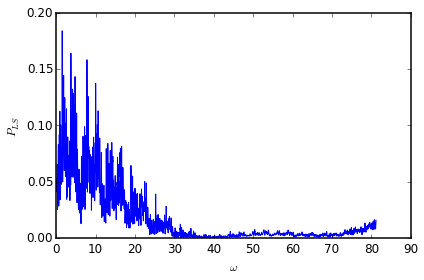

In [22]:
# calculate and plot LS periodogram
P_LS = lomb_scargle(bjds, mags, magerrs, omegas) # COMPLETE
plt.plot(omegas, P_LS)
plt.xlabel('$\omega$')
plt.ylabel('$P_{LS}$')

In [23]:
# provided: define function to find best period
def LS_peak_to_period(omegas, P_LS):
    """find the highest peak in the LS periodogram and return the corresponding period."""
    max_freq = omegas[np.argmax(P_LS)]
    return 2*np.pi/max_freq

In [24]:
# run function to find best period
best_period = LS_peak_to_period(omegas, P_LS)
print "Best period: {} days".format(best_period)

Best period: 4.17880545808 days


## Exercise 4
Complete this function that returns the phase of an observation (in the range 0-1) given its period.  For simplicity set the zero of the phase to be the time of the initial observation.

Hint: Consider the python modulus operator, `%`.

Add a keyword that allows your function to have an optional user-settable time of zero phase.

In [25]:
# define function to phase lightcurves
def phase(time, period, t0 = None):
    """ Given an input array of times and a period, return the corresponding phase."""
    if t0 is None:
        t0 = time[0]
    return ((time - t0)/period) % 1 # COMPLETE

## Exercise 5

Plot the phased lightcurve at the best-fit period.

In [26]:
# define function to plot phased lc
def plot_phased_lc(mjds, mags, magerrs, period, t0=None):
    phases = phase(mjds, period, t0=t0) # COMPLETE
    plt.errorbar(phases,mags,yerr=magerrs, #COMPLETE
        fmt = '_', capsize=0)
    plt.xlabel('Phase')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()

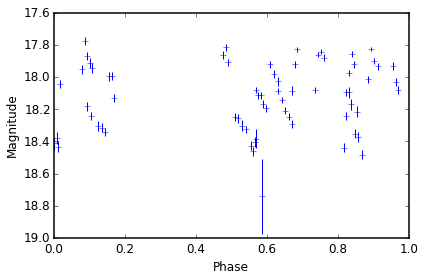

In [27]:
# run function to plot phased lc
plot_phased_lc(bjds, mags, magerrs, best_period)

How does that look?  Do you think you have the right period?

Try re-running your analysis using the `alt_frequency_grid` command, searching the 0.4 - 0.8 day period range.

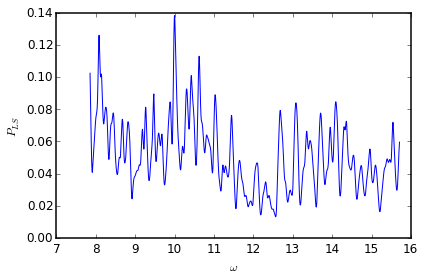

In [38]:
omegas = alt_frequency_grid(.4,.8)
P_LS = lomb_scargle(bjds, mags, magerrs, omegas)
plt.plot(omegas, P_LS)
plt.xlabel('$\omega$')
plt.ylabel('$P_{LS}$')

Best period: 0.628409805154 days


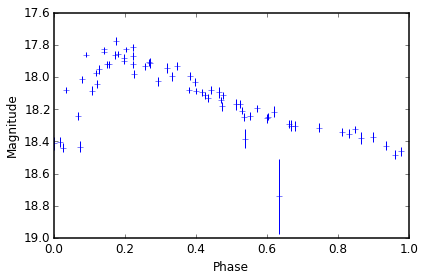

In [39]:
best_period = LS_peak_to_period(omegas, P_LS)
print "Best period: {} days".format(best_period)
plot_phased_lc(bjds, mags, magerrs, best_period)

## [Challenge] Exercise 6: Calculating significance of the period detection

Real data may have *aliases*--frequency components that appear because of the sampling of the data, such as once per night.  Bootstrap significance tests, which shuffle the data values around but keep the times the same, can help rule these out.

Calculate the chance probability of finding a LS peak higher than the observed value in random data observed at the specified intervals: use `lomb_scargle_bootstrap` and `np.percentile` to find the 95 and 99 percent significance levels and plot them over the LS power.



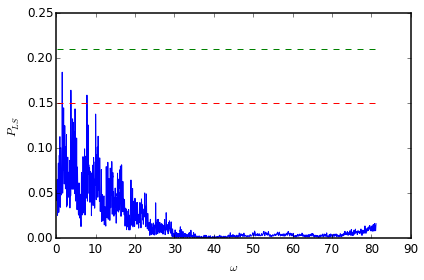

In [34]:
D = lomb_scargle_bootstrap(mjds, mags, magerrs, omegas,
   generalized=True, N_bootstraps=1000) # COMPLETE
sig99, sig95 = np.percentile(D, [99, 95]) # COMPLETE
plt.plot(omegas, P_LS)
plt.plot([omegas[0],omegas[-1]], sig99*np.ones(2),'--')
plt.plot([omegas[0],omegas[-1]], sig95*np.ones(2),'--')
plt.xlabel('$\omega$')
plt.ylabel('$P_{LS}$')

## [Challenge] Exercise 7: Find periods of other sources

Now try finding the periods of these sources:

* variableB 
* variableC (use `alt_frequency_grid`) 
* variableD (very hard with LS! use `alt_frequency_grid`)

## [Challenge] Exercise 8: Compute all periods

This is a big one: can you compute periods for *all* of the sources in our database with variability above XX amplitude?


## [Challenge] Exercise 9: gatspy

Try using the [`gatspy`](http://www.astroml.org/gatspy/) package to search for periods.  It uses a slightly different interface but has several nice features, such as automatic zooming on candidate frequency peaks.

Finding optimal frequency:
 - Estimated peak width = 0.0965
 - Using 5 steps per peak; omega_step = 0.0193
 - User-specified period range:  0.4 to 0.8
 - Computing periods at 409 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
0.628048921484


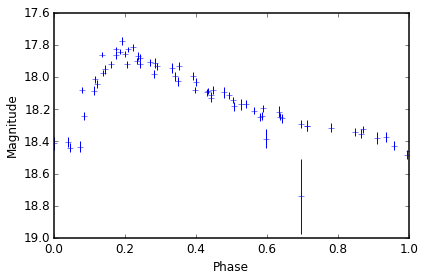

In [45]:
import gatspy
ls = gatspy.periodic.LombScargleFast().fit(bjds,mags,magerrs)
#ls.optimizer.period_range = (0.2,1.2)
ls.optimizer.period_range = (0.4,0.8)
gatspy_period = ls.best_period
print gatspy_period
plot_phased_lc(bjds, mags, magerrs, gatspy_period)

## [Challenge] Exercise 10: Alternate Algorithms 

Lomb-Scargle is equivalent to fitting a sinusoid to the phased data, but many kinds of variable stars do not have phased lightcurves that are well-represented by a sinusoid.  Other algorithms, such as those that attempt to minimize the dispersion within phase bins over a grid of trial phases, may be more successful in such cases.  See [Graham et al (2013)](http://adsabs.harvard.edu/abs/2013MNRAS.434.3423G) for a review.  




## [Challenge] Exercise 10: Multi-harmonic fitting 

AstroML also includes [code](http://www.astroml.org/book_figures/chapter10/fig_LINEAR_LS.html) (see also `astroML.time_series.multiterm_periodogram`) for including multiple Fourier components in the fit, which can better fit arbitrary lightcurves.

*Other effects to consider*



Many eclipsing binaries have primary and secondary eclipses, often with comparable depths.  The period found by LS (which fits a single sinusoid) will thus often be only half of the true period.  Plotting the phased lightcurve at double the LS period is often the easiest way to determine the true period. 

## References and Further Reading

Scargle, J. 1982, [ApJ 263, 835](http://adsabs.harvard.edu/abs/1982ApJ...263..835S)

Zechmeister, M., and Kürster, M. 2009, [A&A 496, 577](http://adsabs.harvard.edu/abs/2009A%26A...496..577Z)

Graham, M. et al. 2013, [MNRAS 434, 3423](http://adsabs.harvard.edu/abs/2013MNRAS.434.3423G)

[Statistics, Data Mining, and Machine Learning in Astronomy](http://press.princeton.edu/titles/10159.html) (Ivezic, Connolly, VanderPlas, & Gray)